In [ ]:
!pip install torch torchvision matplotlib scikit-learn -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Data --------------------
data_dir = "/content/drive/MyDrive/dataset-resized"  # change this to your dataset path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # must be before Normalize
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# -------------------- Model --------------------
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # freeze backbone

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_dataset.classes))  # new head
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Epoch 1/10 - Train Loss: 1.2206, Val Loss: 0.9043, Val Acc: 0.6877
Epoch 2/10 - Train Loss: 0.7953, Val Loss: 0.7546, Val Acc: 0.7154
Epoch 3/10 - Train Loss: 0.6637, Val Loss: 0.6921, Val Acc: 0.7273
Epoch 4/10 - Train Loss: 0.5944, Val Loss: 0.6537, Val Acc: 0.7688
Epoch 5/10 - Train Loss: 0.5541, Val Loss: 0.5946, Val Acc: 0.7945
Epoch 6/10 - Train Loss: 0.5019, Val Loss: 0.5841, Val Acc: 0.7984
Epoch 7/10 - Train Loss: 0.5020, Val Loss: 0.5740, Val Acc: 0.8083
Epoch 8/10 - Train Loss: 0.4959, Val Loss: 0.5760, Val Acc: 0.8043
Epoch 9/10 - Train Loss: 0.4990, Val Loss: 0.5849, Val Acc: 0.7964
Epoch 10/10 - Train Loss: 0.4836, Val Loss: 0.5688, Val Acc: 0.8004

Best Validation Accuracy: 0.8083


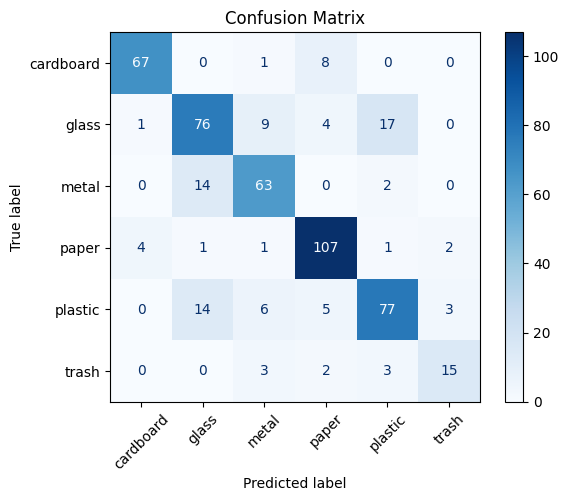

Final Accuracy: 0.8004
Precision: 0.7999
Recall: 0.8004


In [ ]:
# -------------------- Training Loop --------------------
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=10):
    best_acc = 0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    y_true, y_pred = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, correct = 0.0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model, history, y_true, y_pred, best_acc


# -------------------- Train & Evaluate --------------------
model, history, y_true, y_pred, best_acc = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader,
    epochs=10
)

print(f"\nBest Validation Accuracy: {best_acc:.4f}")

# -------------------- Confusion Matrix --------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# -------------------- Metrics --------------------
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec = recall_score(y_true, y_pred, average="weighted")

print(f"Final Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


In [ ]:
import random
from torch.utils.data import Subset

# -------------------- Split off 10 random test images --------------------
indices = list(range(len(full_dataset)))
random.shuffle(indices)

test_indices = indices[:10]
train_val_indices = indices[10:]

test_dataset = Subset(full_dataset, test_indices)
train_val_dataset = Subset(full_dataset, train_val_indices)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 2013, Val: 504, Test: 10



📊 Test Results (10 random images):
True: glass | Pred: glass
True: paper | Pred: paper
True: metal | Pred: metal
True: paper | Pred: paper
True: plastic | Pred: plastic
True: paper | Pred: paper
True: cardboard | Pred: paper
True: metal | Pred: metal
True: glass | Pred: glass
True: metal | Pred: metal


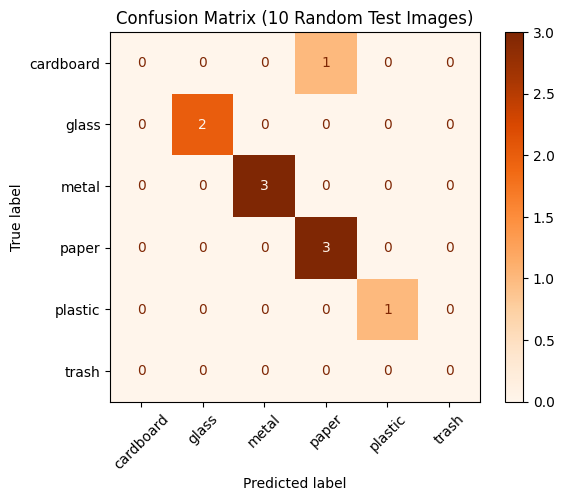

In [ ]:
# -------------------- Test Evaluation --------------------
model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())

print("\n📊 Test Results (10 random images):")
for true, pred in zip(y_true_test, y_pred_test):
    print(f"True: {full_dataset.classes[true]} | Pred: {full_dataset.classes[pred]}")

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=list(range(len(full_dataset.classes))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=full_dataset.classes)
disp.plot(cmap=plt.cm.Oranges, xticks_rotation=45)
plt.title("Confusion Matrix (10 Random Test Images)")
plt.show()


In [ ]:
import torch

# Example dummy input (must match your model input size)
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # For image models with 3 channels, 224x224 input

# Export the model
onnx_file = "trained_model.onnx"
torch.onnx.export(
    model,                   # your trained model
    dummy_input,             # a sample input
    onnx_file,               # output file name
    export_params=True,      # store the trained parameter weights
    opset_version=11,        # ONNX version
    do_constant_folding=True, # optimize constant values
    input_names=["input"],   # model input name
    output_names=["output"], # model output name
    dynamic_axes={           # allow variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"Model has been successfully exported to {onnx_file}")


Model has been successfully exported to trained_model.onnx


In [ ]:
import torch

# Example: CIFAR-10 input shape (3, 32, 32)
dummy_input = torch.randn(1, 3, 32, 32, device=device)

onnx_file = "trained_model.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_file,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)

print(f"✅ Model exported as {onnx_file}")


✅ Model exported as trained_model.onnx
